# SIR Monte-Carlo simulations

This notebook introduces the Contagion class. The core method Contagion.contagion is a Monte-Carlo simulator for SIR type of infection spreading on static, complex networks. The numerical results are also compared to analytical predictions for validation.

## Load modules

In [1]:
import sys
sys.path.append("/home/andreasko/TU/Git/contagion/")

from contact_dynamics import Contagion
import networkx as nx

import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import gamma, erlang, expon
from scipy.special import gdtr #gamma distribution cumulative density function
from itertools import islice

import matplotlib.pyplot as plt
import seaborn as sns #not necessary
%matplotlib inline
sns.set(palette="dark") #not necessary


## Simulation parameters

In [2]:
infection_rate = 1.
recovery_rate = 0.9
ensemble = int(1e5)

kwargs = {
"infection_rate" : infection_rate,
"recovery_rate" : recovery_rate,
"ensemble" : ensemble,
"statistics" : True,
"verbose" : True,
"rtol" : 0.
}

## Examples
### 1) two nodes 
Two nodes connected through a link. The transmission time is a random variable drawn from an exponential distribution.

In [15]:
weight = 0.5
edgelist = [(0, 1, weight), (1, 0, weight)]
simulator = Contagion(edgelist)
simulator.contagion(source = 0, **kwargs )
sim = simulator.arrival_statistics[1,:]
sim = sim[sim > 0]

  2%|▏         | 1643/100000 [00:00<00:06, 16295.24it/s]

graph has been saved in self.graph
number of nodes and edges: 2 2


100%|██████████| 100000/100000 [00:11<00:00, 9000.11it/s]
/home/andreasko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


#### Analysis 

In [ ]:
x = np.linspace(0.001, hist[1][-1], 1000)
pdf = expon.pdf(x, scale=1./infection_rate/weight)
mean_pdf = expon.stats(scale=1./infection_rate/weight, moments="m")

#### Plot results

average arrival time: 1.99862564278 , predicted: 2.0


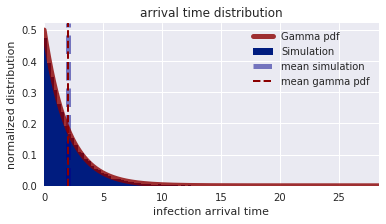

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(6,3))
hist = ax.hist(sim, bins=100, normed=True, label="Simulation")
ax.set_title("arrival time distribution")
ax.set_xlabel("infection arrival time")
ax.set_ylabel("normalized distribution")
ax.plot(x, pdf, c='darkred', lw=5, alpha=0.8, label='Gamma pdf')

top = max(hist[0]) + 0.05
ax.vlines(np.mean(sim), 0, top, colors="darkblue", alpha=0.5, lw=5, linestyle="dashed", label="mean simulation")
ax.vlines(mean_pdf, 0, top, colors="darkred", alpha=1, lw=2, linestyle="dashed",label="mean gamma pdf")
ax.set_xlim(0,max(hist[1]))
ax.set_ylim(0,top)
ax.legend()

print "average arrival time:", np.mean(sim), ", predicted:", mean_pdf

---
### 2) path-graph
A line of nodes connected by (undirected) links. The outbreak location is the first node and the target is chosen randomly. The infection arrival time is a sum of random variables that are all drawn from an exponential and thus follows a gamma distribution. 

In [6]:
Nnodes = 6
source = 0
weight = 2.
G = nx.path_graph(Nnodes)
for s,t in G.edges():
    G[s][t]["weight"] = weight
simulator = Contagion(G)
simulator.contagion(source = 0, **kwargs )

/home/andreasko/TU/Git/contagion/contact_dynamics.py:229: RuntimeWarning: invalid value encountered in multiply
  arrival_statistics = np.empty((Nnodes, ensemble))*np.nan #arrival statistics for one predefined source node
  1%|          | 524/100000 [00:00<00:18, 5237.32it/s]

graph has been saved in self.graph
number of nodes and edges: 6 10


100%|██████████| 100000/100000 [00:17<00:00, 5775.99it/s]


#### Analysis

In [ ]:
target = np.random.randint(1,Nnodes)
a = nx.shortest_path_length(simulator.graph,source=source, target=target)
x = np.linspace(gamma.ppf(0.001, a), gamma.ppf(0.999, a), 1000)
pdf = gamma.pdf(x, a, scale=1./infection_rate/weight)
mean_pdf = gamma.stats(a, scale=1./infection_rate/weight, moments="m")

#### Plot results

/home/andreasko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Source 0 to target 3
Topological shortest path length: 3
Average infection arrival time 1.50222642083 (estimated to be 1.5)


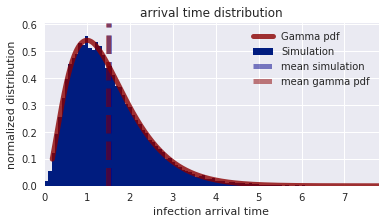

In [7]:
sim = simulator.arrival_statistics[target, simulator.arrival_statistics[target,:] > 0 ]
fig, ax = plt.subplots(1, 1, figsize=(6,3))
hist = ax.hist(sim, bins=100, normed=True, label="Simulation")
ax.set_title("arrival time distribution")
ax.set_xlabel("infection arrival time")
ax.set_ylabel("normalized distribution")
ax.plot(x, pdf, c='darkred', lw=5, alpha=0.8, label='Gamma pdf')

top = max(hist[0]) + 0.05
ax.vlines(np.mean(sim), 0, top, colors="darkblue", alpha=0.5, lw=5, linestyle="dashed", label="mean simulation")
ax.vlines(mean_pdf, 0, top, colors="darkred", alpha=0.5, lw=5, linestyle="dashed",label="mean gamma pdf")
ax.set_xlim(0,max(hist[1]))
ax.set_ylim(0,top)
ax.legend()

print "Source {} to target {}".format(source, target)
print "Topological shortest path length:", a
print "Average infection arrival time", np.mean(sim), "(estimated to be {})".format(mean_pdf)

---
### 4) parallel paths

In [8]:
def parallel_paths(Npaths, Nlength):
    vstep = 1./(Npaths+1.)
    hstep = 1./(Nlength+2.)
    idx = 2
    hidx = 2*hstep
    vidx = vstep

    pos = {0: (0.5, hstep), 1: (0.5, 1.-hstep), idx: (vidx, hidx)}
    edgelist = [(0,2)]
    for jj in xrange(Nlength-2):
        edgelist.append((idx,idx+1))
        hidx += hstep
        idx += 1
        pos[idx] = (vidx, hidx)
    edgelist.append((idx,1))
    #Nlength -= 1 #!!!
    for ii in xrange(Npaths-1):
        vidx += vstep
        hidx = 2*hstep
        idx += 1
        edgelist.append((0,idx))
        pos[idx] = (vidx, hidx)
        for jj in xrange(Nlength-2):
            edgelist.append((idx,idx+1))
            idx += 1
            hidx += hstep
            pos[idx] = (vidx, hidx)
        #Nlength -= 1 #!!!
        edgelist.append((idx,1))
    edgelist += [(v,u) for u,v in edgelist]
    edgelist = np.array(edgelist)
    return edgelist, pos

graph has been saved in self.graph
number of nodes and edges: 7 20


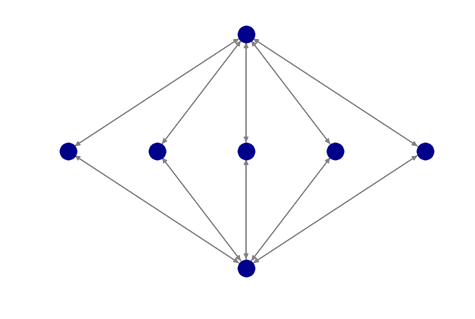

In [9]:
Nlength = 2
Npaths = 5
edgelist, pos = parallel_paths(Npaths, Nlength)
simulator = Contagion()
simulator.load(edgelist, directed=True, strongly_connected=False)
graph = simulator.graph
nx.draw(simulator.graph, pos=pos, node_color="darkblue", edge_color="gray")

#### Simulation

In [10]:
simulator.contagion(source = 0, **kwargs)
target = 1
sim = simulator.arrival_statistics[target, simulator.arrival_statistics[target,:] > 0 ]
hist, bins = np.histogram(sim, bins=100, density=True)

100%|██████████| 100000/100000 [00:30<00:00, 3298.97it/s]
/home/andreasko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


#### Analysis 

In [11]:
x = np.linspace(0.01, bins[-1], 100)
path_prob = (1.-recovery_rate/(recovery_rate + infection_rate))**Nlength
pdf = Npaths * \
        gamma.pdf(x, Nlength, scale=infection_rate) * path_prob * \
        ( (1. - gdtr(infection_rate, Nlength, x)) * path_prob + 1. - path_prob )**Npaths
pdf /= pdf.sum()*(x[1]-x[0]) #normalize

#### Plot results

Source 0 to target 1
Topological shortest path length: 3
Average infection arrival time 1.45400011045 (estimated to be 1.5)


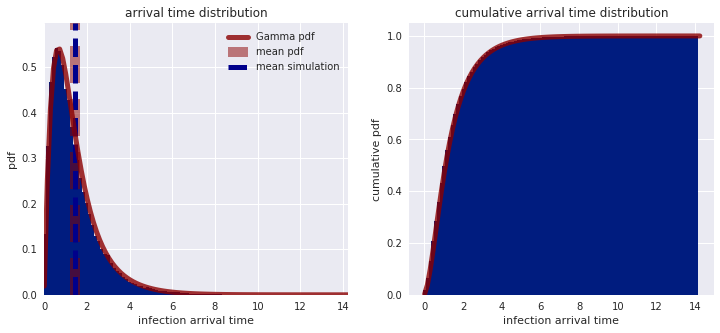

In [14]:
fig, (ax,ax2) = plt.subplots(1, 2, figsize=(12,5))
#hist = ax.hist(sim, bins=100, normed=True, label="Simulation")
ax.bar(bins[:-1], hist, width=(bins[1]-bins[2]))
ax.set_title("arrival time distribution")
ax.set_xlabel("infection arrival time")
ax.set_ylabel("pdf")

ax.plot(x, pdf, c='darkred', lw=5, alpha=0.8, label='Gamma pdf')
top = max(hist) + max(hist)/10.
ax.set_xlim(0,bins[-1])
ax.set_ylim(0,top)

ax.vlines(np.sum(x*pdf)/pdf.sum(), 0, top, colors="darkred", alpha=0.5, lw=10, linestyle="dashed", label="mean pdf")
ax.vlines(np.mean(sim), 0, top, colors="darkblue", alpha=1, lw=5, linestyle="dashed", label="mean simulation")
ax.legend()

ax2.bar(bins[:-1], np.cumsum(hist)*(bins[1] - bins[0]), width=(bins[1]-bins[2]))
ax2.plot(x, np.cumsum(pdf)*(x[1] - x[0]), c='darkred', lw=5, alpha=0.8, label='Gamma pdf')
ax2.set_title("cumulative arrival time distribution")
ax2.set_xlabel("infection arrival time")
ax2.set_ylabel("cumulative pdf")

print "Source {} to target {}".format(source, target)
print "Topological shortest path length:", a
print "Average infection arrival time", np.mean(sim), "(estimated to be {})".format(mean_pdf)

---
### 5) Graphs containing loops
This example shows when the assumption of independent paths fails.

In [17]:
def cyclic_graph(Npaths, Nlength, Ntail):
    vstep = 1./(Npaths+1.)
    hstep = 1./(Ntail+Nlength+2.)
    idx = 2
    hidx = 2*hstep
    vidx = vstep

    idx0 = 1
    pos = {idx0: (0.5, hstep), 0: (0.5, 1.-hstep)}
    if Ntail > 0:
        edgelist = [(idx0,idx)]
        pos[idx] = (0.5, hidx)
        hidx += hstep
        idx_tail = idx
        idx += 1
    else:
        idx0 = 1
    for jj in xrange(1, Ntail):
        edgelist.append((idx-1, idx))
        pos[idx] = (0.5, hidx)
        hidx += hstep
        idx_tail = idx
        idx += 1

    edgelist.append((idx_tail, idx))
    pos[idx] = (vidx, hidx)
    for jj in xrange(Nlength-2):
        edgelist.append((idx,idx+1))
        hidx += hstep
        idx += 1
        pos[idx] = (vidx, hidx)
    edgelist.append((idx,0))

    for ii in xrange(Npaths-1):
        vidx += vstep
        hidx = (Ntail+2)*hstep
        idx += 1
        edgelist.append((idx_tail,idx))
        pos[idx] = (vidx, hidx)
        for jj in xrange(Nlength-2):
            edgelist.append((idx,idx+1))
            idx += 1
            hidx += hstep
            pos[idx] = (vidx, hidx)
        edgelist.append((idx,0))
    edgelist += [(v,u) for u,v in edgelist]
    edgelist = np.array(edgelist)
    return edgelist, pos

graph has been saved in self.graph
number of nodes and edges: 20 56


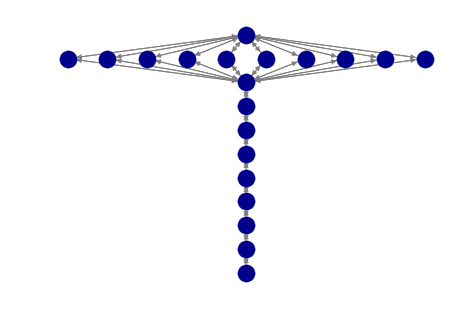

In [23]:
Nlength = 2
Npaths = 10
Ntail = 8
edgelist, pos = cyclic_graph(Npaths, Nlength, Ntail)
simulator = Contagion()
simulator.load(edgelist, directed=True, strongly_connected=False)
nx.draw(simulator.graph, pos=pos, node_color="darkblue", edge_color="gray")

#### Simulation

In [24]:
target = 1
kwargs["ensemble"] = int(1e6)
simulator.contagion(source = 0, **kwargs)
sim = simulator.arrival_statistics[target, simulator.arrival_statistics[target,:] > 0 ]
hist, bins = np.histogram(sim, bins=100, density=True)

100%|██████████| 1000000/1000000 [14:07<00:00, 1180.24it/s]
/home/andreasko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


#### Analysis

In [31]:
path_length = Nlength + Ntail
x = np.linspace(0.01, bins[-1], 100)
path_prob = (1.-recovery_rate/(recovery_rate + infection_rate))**Nlength
pdf = Npaths * \
        gamma.pdf(x, path_length, scale=infection_rate) * path_prob * \
        ( (1. - gdtr(infection_rate, path_length, x)) * path_prob + 1. - path_prob )**Npaths
pdf /= pdf.sum()*(x[1]-x[0]) #normalize
mean_pdf = np.sum(x * pdf) / pdf.sum()

#### Plot results

Source 0 to target 1
Topological shortest path length: 3
Average infection arrival time 9.06518239538 (estimated to be 7.69129256131)


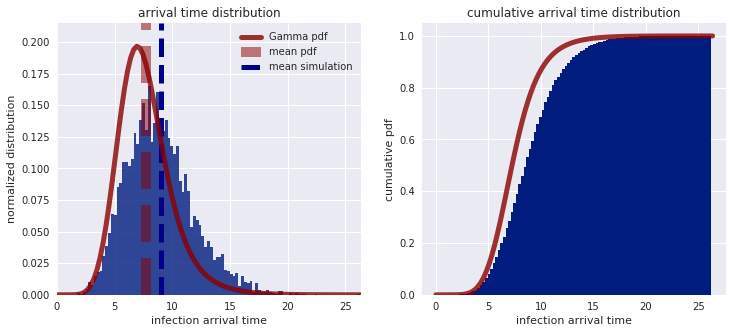

In [32]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax.bar(bins[:-1], hist, width=(bins[1]-bins[2]), alpha=0.8)
ax.set_title("arrival time distribution")
ax.set_xlabel("infection arrival time")
ax.set_ylabel("normalized distribution")

ax.plot(x, pdf, c='darkred', lw=5, alpha=0.8, label='Gamma pdf')
top = max(hist) + 0.05
ax.set_xlim(0,bins[-1])
ax.set_ylim(0,top)

ax.vlines(np.sum(x*pdf)/pdf.sum(), 0, top, colors="darkred", alpha=0.5, lw=10, linestyle="dashed", label="mean pdf")
ax.vlines(np.mean(sim), 0, top, colors="darkblue", alpha=1, lw=5, linestyle="dashed", label="mean simulation")
ax.legend()

ax2.bar(bins[:-1], np.cumsum(hist)*(bins[1] - bins[0]), width=(bins[1]-bins[2]))
ax2.plot(x, np.cumsum(pdf)*(x[1] - x[0]), c='darkred', lw=5, alpha=0.8, label='Gamma pdf')
ax2.set_title("cumulative arrival time distribution")
ax2.set_xlabel("infection arrival time")
ax2.set_ylabel("cumulative pdf")

print "Source {} to target {}".format(source, target)
print "Topological shortest path length:", a
print "Average infection arrival time", np.mean(sim), "(estimated to be {})".format(mean_pdf)

---
### 6) Empirical network 

file successfully loaded...

The node IDs have to run continuously from 0 to Number_of_nodes-1.
Node IDs have been changed according to the requirement.
-----------------------------------

graph has been saved in self.graph
number of nodes and edges: 62 304


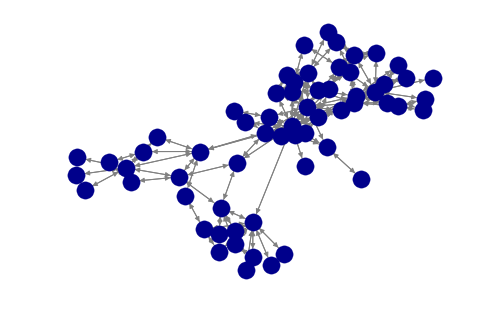

In [3]:
fname = "data_terrorists.txt"
simulator = Contagion(fname, delimiter=",", comments="%")
nx.draw(simulator.graph, node_color="darkblue", edge_color="gray")

#### Simulate with one outbreak origin

In [5]:
source = np.random.randint(simulator.graph.number_of_nodes())
simulator.contagion(source = source, **kwargs)

100%|██████████| 100000/100000 [05:53<00:00, 283.05it/s]


#### Simulate with a second outbreak origin 

In [10]:
source2 = np.random.randint(simulator.graph.number_of_nodes())
simulator2 = Contagion(fname, delimiter=",", comments="%", verbose=False)
simulator2.contagion(source = (source, source2), **kwargs)

  0%|          | 0/100000 [00:00<?, ?it/s]

file successfully loaded...

The node IDs have to run continuously from 0 to Number_of_nodes-1.
Node IDs have been changed according to the requirement.
-----------------------------------

graph has been saved in self.graph
number of nodes and edges: 62 304


100%|██████████| 100000/100000 [05:40<00:00, 293.56it/s]


#### Plot results

/home/andreasko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/home/andreasko/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


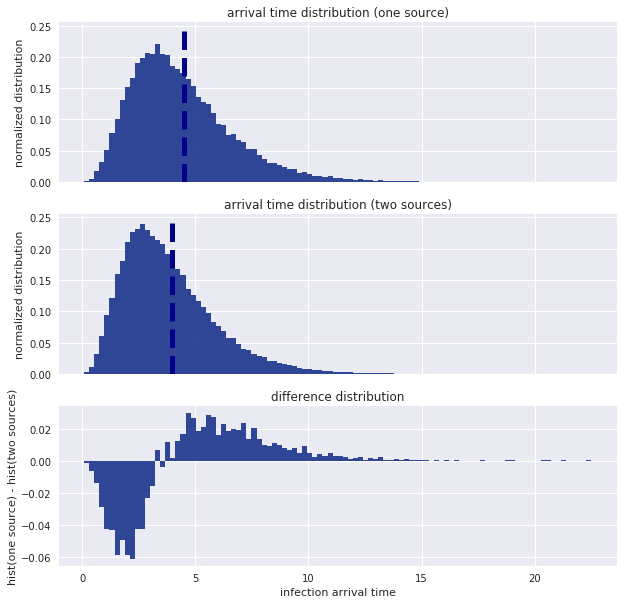

In [25]:
target = np.random.randint(simulator.graph.number_of_nodes())
sim = simulator.arrival_statistics[target, simulator.arrival_statistics[target,:] > 0 ]
hist, bins = np.histogram(sim, bins=100, density=True)
sim2 = simulator2.arrival_statistics[target, simulator2.arrival_statistics[target,:] > 0 ]
hist2, bins = np.histogram(sim2, bins=bins, density=True)
top = max(hist) + max(hist)/10.

fig, (ax, ax2, ax3) = plt.subplots(3,1, figsize=(10,10), sharex=True)
ax.bar(bins[:-1], hist, width=(bins[1]-bins[2]), alpha=0.8)
ax.vlines(np.mean(sim), 0, top, colors="darkblue", alpha=1, lw=5, linestyle="dashed", label="mean simulation")
ax.set_title("arrival time distribution (one source)")
ax.set_ylabel("normalized distribution")

ax2.bar(bins[:-1], hist2, width=(bins[1]-bins[2]), alpha=0.8)
ax2.vlines(np.mean(sim2), 0, top, colors="darkblue", alpha=1, lw=5, linestyle="dashed", label="mean simulation")
ax2.set_title("arrival time distribution (two sources)")
ax2.set_ylabel("normalized distribution")

ax3.bar(bins[:-1], hist-hist2, width=(bins[1]-bins[2]), alpha=0.8)
ax3.set_title("difference distribution")
ax3.set_xlabel("infection arrival time")
ax3.set_ylabel("hist(one source) - hist(two sources)")

#### Relative error trajectory

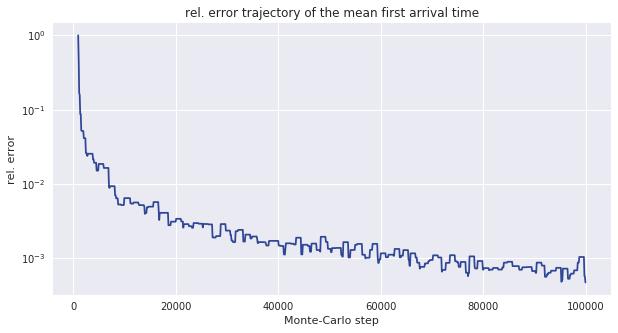

In [33]:
fig, ax = plt.subplots(1, figsize=(10,5))
x = xrange(1000, ensemble, 100)
ax.semilogy(x, simulator.error[10:], alpha=0.8)
ax.set_title("rel. error trajectory of the mean first arrival time")
ax.set_xlabel("Monte-Carlo step")
ax.set_ylabel("rel. error")